**Author: Antonio Moreno Martin**

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
def create_features(df):
    '''
    Crearemos features de time series basados en el index para estudiar luego su comportamiento
    '''
    
    df = df.set_index('Fecha')
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df

def plot_prediction(df_total, df):
    fig = make_subplots(rows=1, cols=1)


    train =df_total.loc[:(len(df)-1)]
    prediction = df_total.loc[(len(df)-1):]
    prediction

    fig.add_trace(
        name = "Precio Real",
        go.Line(x = train.Fecha, y = train.Precio),
        row=
        1, col=1
    )
    fig.add_trace(
        name = "Precio Predicho",
        go.Line(x = prediction.Fecha, y = prediction.Precio),
        row=
        1, col=1
    )
    fig
    fig.show()

### Read and gather downloaded data

In [4]:
# Leer y gather data
input = "/Users/amm/Documents/Github/Data/Gasolina/source/Madrid_alcampo_gasolina_98_E5/"
files = glob.glob(input + '*.xls')

df = pd.concat([pd.read_excel(file) for file in files], ignore_index=True)

df['Fecha'] = pd.to_datetime(df['Fecha'])
df.sort_values(by='Fecha', inplace = True)

In [5]:
df.tail()

,Fecha,Precio
131,2022-12-01,1.639903
132,2023-01-01,1.619419
133,2023-02-01,1.648428
134,2023-03-01,1.654032
135,2023-04-01,1.650000


In [6]:

fig = px.line(df, x = 'Fecha', y = 'Precio', title = 'Gasolina 98 E5 Madrid 2020 - 2023')
fig.show()

In [8]:

df_study = create_features(df)
fig = px.box(df_study, x= "month", y="Precio")
fig.show()

In [9]:

# Determinar si es un random walk o no
# Vamos a determinar si es un random walk o no. Recordar que es un proceso donde hay mismas posibilidades tanto de ir hacia arriba o hacia abajo por un número aleatorio.
# Step 1: Ver si existe una tendencia. En este caso, parece que puede haberlo ya que año a año ha ido incrementando.
## 1.a Vamos a descomponerlo en tendencia, temporalidad y residuos

In [10]:

advanced_decomposition = STL(df['Precio'], period = 12).fit()

fig = make_subplots(rows=4, cols=1, subplot_titles=("Observed", "Trend", "Seasonal", "Residuals"))

fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.observed),
    row=1, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.trend),
    row=2, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.seasonal),
    row=3, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.resid),
    row=4, col=1
)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Efectivamente, vemos una tendencia en la segunda gráfica. Vamos a salir de dudas con test ADF para ver el ACF(Autocorrelation function):

ADF Statistic: -1.3675547758560522
p-value: 0.5977281831466056


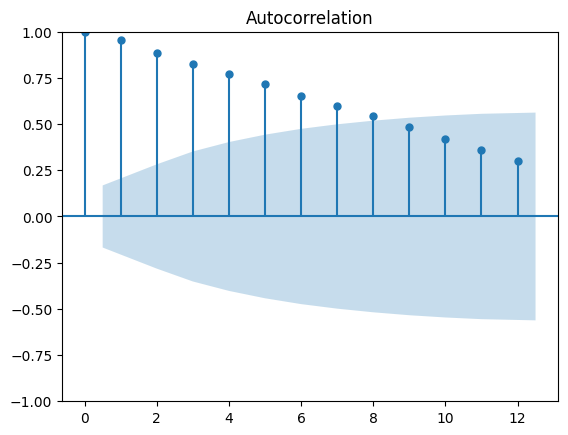

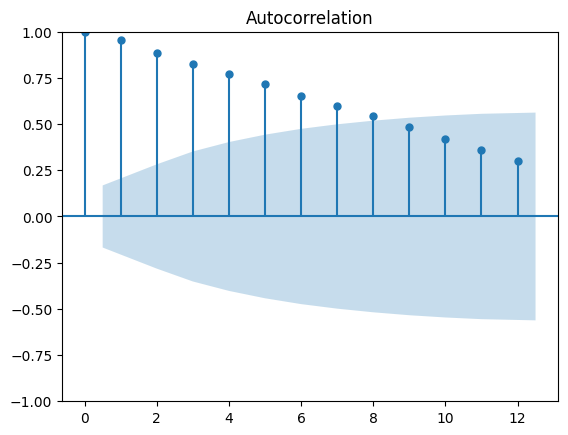

In [11]:
ADF_result = adfuller(df.Precio)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

plot_acf(df.Precio, lags=12) # Vemos como hay una relación linela en las muestras y por tanto, es no estacionario. Dentro del confidence interval se considera que es como tener 

In [12]:
## ACF PLOT

## Plot ACF

ADF Statistic: 0.009352999999999945
p-value: 0.029034000000000004
ADF Statistic: -3.4934137634895404
p-value: 0.008157862471342342


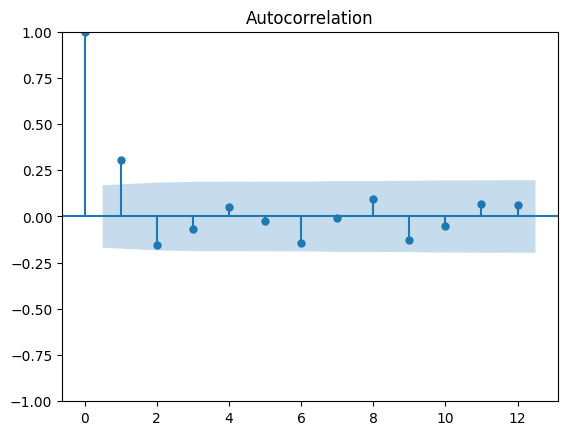

In [13]:

# Como el p valor es 0.79 y es mayor que 0.05, no podemos rechazar la null hyphotesis y por tanto es no estacionacionaria. Por ende, tennemos que diferenciar.
diff_gasolina = np.diff(df['Precio'], n = 1)
print(f'ADF Statistic: {diff_gasolina[0]}')
print(f'p-value: {diff_gasolina[1]}')
plot_acf(diff_gasolina, lags = 12) # Vemos como tenemos coeficientes significativos después de 0, esto q  uiere decir que es un random walk claramente

ADF_result = adfuller(diff_gasolina)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

Vemos como tiene un comportamiento <mark> SINUSOIDAL pattern</mark> 

# Moving Average (MA)

<mark>Uno de los motivos por los que hariamos MA, sería al dibujar el PACF (funcion parcial de autocorrelacion), donde tendríamos que ver un decay LINEAL. Recordamos que el MA era decay exponencial</mark>

In [14]:
df_aux = df.copy()
df_aux = df_aux.set_index('Fecha')
indices_diff = df_aux[1:].index.tolist()

df_diff = pd.DataFrame({'diff_gasolina': diff_gasolina})
df_diff.index = indices_diff

mod = ARIMA(df_diff, order=(0,0,1))
res = mod.fit()

predict = res.get_prediction(start = '2023-05-01', end = '2023-12-01')
prediction = pd.DataFrame( columns=['predicted_MA'])


### <mark>`len(df) - 1`</mark> se pone ya que cuando diferenciamos, el primer elemento se pierde, y por tanto, no podemos considerar el primer elemento que se encuentra en el lag 0

In [15]:
df_pred =pd.DataFrame({'Fecha':predict.predicted_mean.index, 'Precio':predict.predicted_mean.values})
df_total = pd.concat([df, df_pred])
df_total = df_total.reset_index(drop=True)

df_total['Precio'].loc[(len(df)-1):,] = df_total['Precio'][(len(df)-1):].cumsum()


## PLOT MA PREDICTION

In [16]:
plot_prediction(df_total, df)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Calculate the error with the predictions made

## MSE

- El <mark>len(df)</mark> del modelo con el que hemos construido el MA es en este momento <mark>136</mark>, por ello, para calcular el error compararemos hasta ese número

mae_ma = mean_absolute_error(df'')

# AUTOREGRESSIVE MODEL (AR)

<mark>Al igual que para MA, es necesario dibujar su ACF, pero esta ve en lugar de decaer linealmente, deberíamos cerciorarnos de que decae exponencialmente<br>
Por otra parte, a DIFERENCIA de MA, para conocer su grado MA(p), NO nos basta  con el ACF, en este caso debemos dibujar el PACF y ver donde deja de haber coeficientes no significativos</mark>

## Plot PACF

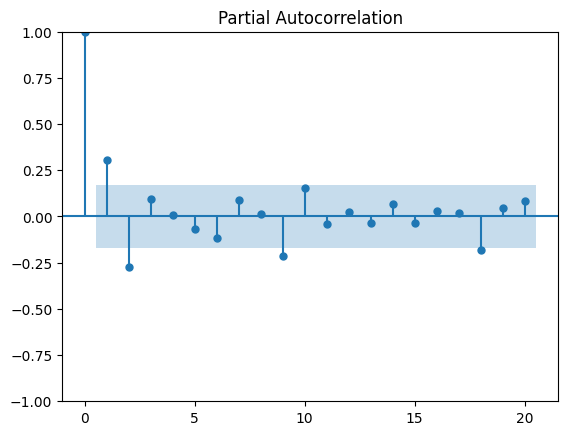

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_gasolina, lags=20);

<mark>Vemos, que a partir del lag 2, los coeficientes dejan de ser significativos, por ende, estamos frente a un AR(2)
<br>
Además, cabe destacar que tiene al igual que el ACF, un comportamiento sinusoidal, por ende, podemos aplicar un modelo ARMA</mark>

In [18]:
mod = ARIMA(df_diff, order=(2,0,0)) # AR(2)
res = mod.fit()

predict = res.get_prediction(start = '2023-05-01', end = '2023-12-01')
prediction = pd.DataFrame( columns=['predicted_MA'])

In [19]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          diff_gasolina   No. Observations:                  135
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 226.340
Date:                Mon, 29 May 2023   AIC                           -444.680
Time:                        20:37:38   BIC                           -433.059
Sample:                    02-01-2012   HQIC                          -439.957
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.005      0.306      0.759      -0.008       0.011
ar.L1          0.3847      0.052      7.359      0.000       0.282       0.487
ar.L2         -0.2674      0.048     -5.615      0.0

- const = 0 y ar.L1 0.3 es igual a phi=0.3 en la ecuación matemática

In [20]:
print(res.params)

const     0.001534
ar.L1     0.384701
ar.L2    -0.267369
sigma2    0.002043
dtype: float64


In [21]:
df_pred =pd.DataFrame({'Fecha':predict.predicted_mean.index, 'Precio':predict.predicted_mean.values})
df_pred

,Fecha,Precio
0,2023-05-01,-0.001696
1,2023-06-01,0.001779
2,2023-07-01,0.002492
3,2023-08-01,0.001836
4,2023-09-01,0.001394
5,2023-10-01,0.001399
6,2023-11-01,0.001519
7,2023-12-01,0.001564


In [22]:
df_diff

,diff_gasolina
2012-02-01,0.009353
2012-03-01,0.029034
2012-04-01,0.028750
2012-05-01,-0.045202
2012-06-01,-0.053198
...,...
2022-12-01,-0.192230
2023-01-01,-0.020484
2023-02-01,0.029009
2023-03-01,0.005604


## PLOT AR PREDICTION

In [23]:
plot_prediction(df_total, df)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# AUTOREGRESSIVE MOVING AVERAGE (ARMA)

<mark>Para identificar si es un ARMA, tenemos que visualizar unos patrones sinusoidales o un patrón decaying TANTO en el ACF Y PACF.</mark>

Referencia:
<br>
<br>
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html
<br>
<br>
<mark> En funcion ARIMA(p, d, q) los parámetros que podemos rellenar para usar un ARMA son p y q, por ende, la d tiene que ser igual a cero cuando construyamos un ARMA model </mark>


En nuestro caso, podemos ver como en ambos casos es sinusoidal, así que procederemos a aplicar un ARMA

## AIC to create the model

In [24]:
def create_opt_ARMA(df_to_predict, grades):
    '''
    Función para fittear distintos ARMAS con todas las combinaciones de grades que le indicaremos, eligiendo el modelo más óptimo (viendo su AIC)
    
    df_to_predict: pandas dataframe
        Es el df ya tratado previamente para poder aplicarle el modelo ARMA y predecir
    
    grades: int MAYOR QUE CERO
        Creará una lista de 0 hasta grades
        
    '''
    grades = list(range(0,grades + 1))
    arma_mods = [ARIMA(df_to_predict, order=(p, 0, q)).fit() for q in grades for p in grades]
    aic = [arma.aic for arma in arma_mods]
    ar = [list(arma.model_orders.values())[2]for arma in arma_mods] # Elegimos el valor 2, ya que en model_orders, es donde se encuentra el parametro p correspondiente al ar
    ma = [list(arma.model_orders.values())[3]for arma in arma_mods]
    
    df_armas = pd.DataFrame(data = zip(ar, ma, aic), columns = ["p", "q", "AIC"])
    df_armas = df_armas.sort_values("AIC") # Ordenamos de MENOR a MAYOR, ya que el menor AIC  
    return df_armas, arma_mods

<mark>The lower the value for AIC, the better the fit of the model. The absolute value of the AIC value is not important. It can be positive or negative.</mark>
<br>
<br>
**Reference**: https://www.statology.org/negative-aic/

In [25]:
df_armas, arma_mods = create_opt_ARMA(df_diff, 3)
df_armas

,p,q,AIC
10,2,2,-444.968045
4,0,1,-444.959854
2,2,0,-444.679706
8,0,2,-444.042710
3,3,0,-443.747544
5,1,1,-443.654607
6,2,1,-443.576769
12,0,3,-443.375736
9,1,2,-443.098486
7,3,1,-441.749996


In [26]:
# Seleccionamos el primer modelo al ser el que tiene menor AIC, por eso elegimos el [0]
arma_model = arma_mods[df_armas.index.tolist()[0]]
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          diff_gasolina   No. Observations:                  135
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 228.484
Date:                Mon, 29 May 2023   AIC                           -444.968
Time:                        20:37:41   BIC                           -427.536
Sample:                    02-01-2012   HQIC                          -437.884
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.005      0.356      0.722      -0.008       0.011
ar.L1         -0.3686      0.099     -3.738      0.000      -0.562      -0.175
ar.L2         -0.8292      0.091     -9.139      0.000      -1.007      -0.651
ma.L1          0.6599      0.116      5.694      0.000       0.433       0.887
ma.L2          0.8691      0.088      9.831      0.000       0.696       1.042
sigma2         0.0020      0.000     13.783      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):               241.27
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model's residuals

Hasta este punto, viendo el AIC, nos damos cuenta que el mejor modelo es el ARMA(2,2). Ahora, debemos <mark>analizar los residuos</mark>, que no dejan de ser la diferencia entre el valor real
<br> y el predicho para ver que dicha diferencia no es random. Eso se mira a través del <mark>QQplot</mark> y corriendo el <mark>Ljung-Boxtest</mark>

In [27]:
residuals = arma_model.resid
residuals

2012-02-01    0.007657
2012-03-01    0.025878
2012-04-01    0.022484
2012-05-01   -0.046450
2012-06-01   -0.038456
                ...   
2022-12-01   -0.116760
2023-01-01   -0.013558
2023-02-01   -0.031248
2023-03-01    0.027991
2023-04-01    0.027048
Length: 135, dtype: float64

### QQ-PLOT

Es una herramienta gráfica para verificar la hipotesis de que nuestro model's residuals tiene distribución normal.
<br> Si el scatterplot se superpone a la lineal, diremos que tiene buen fit 

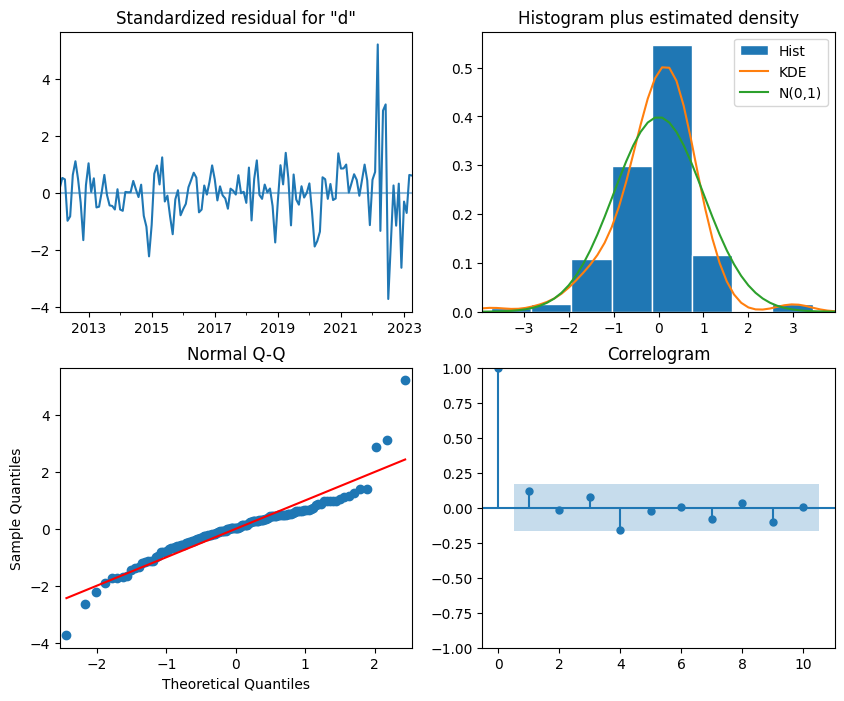

In [28]:
arma_model.plot_diagnostics(figsize=(10, 8));

In [29]:
arma_predict = arma_model.get_prediction(start = '2023-05-01', end = '2023-12-01')

In [30]:
df_pred =pd.DataFrame({'Fecha':arma_predict.predicted_mean.index, 'Precio':arma_predict.predicted_mean.values})
df_total = pd.concat([df, df_pred])
df_total = df_total.reset_index(drop=True)

df_total['Precio'].loc[(len(df)-1):,] = df_total['Precio'][(len(df)-1):].cumsum()
df_total

,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.675526
140,2023-09-01,1.708188
141,2023-10-01,1.695610
142,2023-11-01,1.676889


## PLOT ARMA PREDICTION

In [31]:
plot_prediction(df_total, df)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


